# Import Important Libraries and Dataset

In [84]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import re

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')

from sklearn import linear_model
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/darrenjiang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/darrenjiang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
raw_data = pd.read_csv("data/data.csv")
raw_data.head()

,book_id,text,birth_yr
0,84,"“And now, with the world before me, whither sh...",1797
1,84,"“You have been ill, very ill, and even the con...",1797
2,84,“I intended to reason. This passion is detrime...,1797
3,84,"“How is this? I must not be trifled with, and ...",1797
4,84,"“A few days after, the Turk entered his daught...",1797


# EDA

In [4]:
print(f"Number of books in dataset: {raw_data['book_id'].unique().shape[0]}")
print(f"Number of excerpts in dataset: {raw_data.shape[0]}")

Number of books in dataset: 1524
Number of excerpts in dataset: 8718


In [5]:
data = raw_data.copy()
data['text'] = data['text'].str.strip()
data = data.drop(4996)

,book_id,text,birth_yr,text_len
0,84,"“And now, with the world before me, whither sh...",1797,663
1,84,"“You have been ill, very ill, and even the con...",1797,931
2,84,“I intended to reason. This passion is detrime...,1797,938
3,84,"“How is this? I must not be trifled with, and ...",1797,542
4,84,"“A few days after, the Turk entered his daught...",1797,521


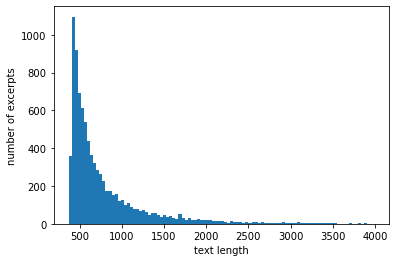

In [6]:
text_len = data['text'].str.len()
data['text_len'] = text_len
plt.hist(
    data['text_len'][data['text_len'] < 4000],
    bins = 100
)
plt.xlabel('text length')
plt.ylabel('number of excerpts')

data.head()

In [7]:
data_ctr = data[data['birth_yr'] >= 1400]
data_ctr = data_ctr[data_ctr['text_len'] <= 4000]

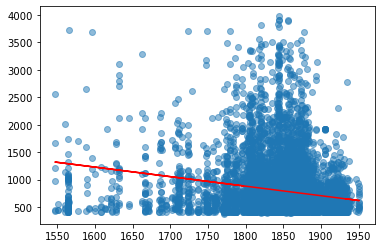

In [8]:
a, b = np.polyfit(
    data_ctr['birth_yr'].to_numpy(), 
    data_ctr['text_len'].to_numpy(), 
    1
)

plt.scatter(
    x = data_ctr['birth_yr'], 
    y = data_ctr['text_len'],
    alpha = 0.5
)

plt.plot(
    data_ctr['birth_yr'].to_numpy(), 
    a * data_ctr['birth_yr'].to_numpy() + b,
    color='red'
) 

In [9]:
text_len.describe()

count     8717.000000
mean       829.661925
std       1039.423894
min        373.000000
25%        473.000000
50%        600.000000
75%        897.000000
max      51354.000000
Name: text, dtype: float64

In [10]:
data['birth_yr'].describe()

count    8717.000000
mean     1852.802340
std        94.942837
min      -431.000000
25%      1831.000000
50%      1861.000000
75%      1893.000000
max      1951.000000
Name: birth_yr, dtype: float64

In [11]:
for i in range(1500, 2000, 100):
    num_excerpts = (
        data[
            (data['birth_yr'] >= i) & 
            (data['birth_yr'] < (i + 100))
        ].shape[0]
    )

    print(f"Timeframe: {i}-{i+100}\tNumber of Excerpts: {num_excerpts}")

Timeframe: 1500-1600	Number of Excerpts: 88
Timeframe: 1600-1700	Number of Excerpts: 136
Timeframe: 1700-1800	Number of Excerpts: 682
Timeframe: 1800-1900	Number of Excerpts: 5743
Timeframe: 1900-2000	Number of Excerpts: 2059


## Outliers

In [12]:
data[data['birth_yr'] < 1400]

,book_id,text,birth_yr,text_len
2750,71894,It was arranged that the band of volunteers sh...,-431,418
2751,71894,"Almost all the officers were of the same mind,...",-431,465
2752,71894,It was now necessary to find some means of cro...,-431,762
2753,71894,They overcame the difficulty however by means ...,-431,468
2754,71894,It was at first proposed to advance in the for...,-431,653
2755,71894,There could no longer be any doubt that the Ca...,-431,652
2756,71894,But Cyrus had long ago foreseen this difficult...,-431,443
2757,71894,"This speech made the desired impression, for t...",-431,435
2758,71894,"Best as well as last of all, was the horse-rac...",-431,587


In [13]:
data[data['text_len'] > 4000].shape

(60, 4)

# Creating Balanced Dataset

In [14]:
data_ctr['birth_ctry'] = data_ctr['birth_yr'] // 100
data_ctr.head()

,book_id,text,birth_yr,text_len,birth_ctry
0,84,"“And now, with the world before me, whither sh...",1797,663,17
1,84,"“You have been ill, very ill, and even the con...",1797,931,17
2,84,“I intended to reason. This passion is detrime...,1797,938,17
3,84,"“How is this? I must not be trifled with, and ...",1797,542,17
4,84,"“A few days after, the Turk entered his daught...",1797,521,17


In [15]:
data_balanced = (
    data_ctr
    .groupby('birth_ctry')
    .apply(
        lambda x: x.sample(2000, replace=True)
    )
    .reset_index(drop=True))

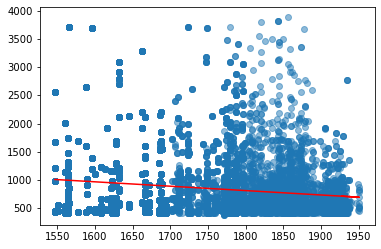

In [16]:
a, b = np.polyfit(
    data_balanced['birth_yr'].to_numpy(), 
    data_balanced['text_len'].to_numpy(), 
    1
)

plt.scatter(
    x = data_balanced['birth_yr'], 
    y = data_balanced['text_len'],
    alpha = 0.5
)

plt.plot(
    data_balanced['birth_yr'].to_numpy(), 
    a * data_balanced['birth_yr'].to_numpy() + b,
    color='red'
) 

In [17]:
data_balanced['birth_yr'].describe()

count    10000.000000
mean      1751.054400
std        130.145832
min       1547.000000
25%       1628.000000
50%       1774.000000
75%       1869.000000
max       1951.000000
Name: birth_yr, dtype: float64

In [18]:
data_balanced['text_len'].describe()

count    10000.000000
mean       844.507700
std        579.251602
min        373.000000
25%        472.000000
50%        608.000000
75%       1006.000000
max       3892.000000
Name: text_len, dtype: float64

# Model Exploration

In [64]:
# Create a copy of the dataset to do text analysis on
data_tfidf = data.copy()

# Process the dataset by removing punctuation for TF-IDF
def preprocess(text):
    text = re.sub(r'[^A-Za-z0-9]+', " ", text)
    text = text.lower()
    return text
data_tfidf["text"] = data_tfidf.get("text").apply(preprocess)
data_tfidf.head()

,book_id,text,birth_yr,text_len
0,84,and now with the world before me whither shou...,1797,663
1,84,you have been ill very ill and even the const...,1797,931
2,84,i intended to reason this passion is detrimen...,1797,938
3,84,how is this i must not be trifled with and i ...,1797,542
4,84,a few days after the turk entered his daughte...,1797,521


In [65]:
# Create a standard TF-IDF using arbitrary parameters
tfidf = TfidfVectorizer(
    sublinear_tf=True,
    analyzer='word',
    max_features=20000,
    tokenizer=nltk.tokenize.word_tokenize,
    stop_words=stopwords.words("english")
)

In [78]:
X = tfidf.fit_transform(data_tfidf["text"])
y = np.array(data_tfidf["birth_yr"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [79]:
model1 = linear_model.LogisticRegression()
model1.fit(X_train, y_train)

LogisticRegression()

In [80]:
y_train_pred = model1.predict(X_train)
y_test_pred = model1.predict(X_test)

In [81]:
def RMSE(y_pred, y):
    return np.sqrt(np.sum(np.square(y - y_pred)) / y.shape[0])

In [82]:
print(f"Training RMSE: {RMSE(y_train_pred, y_train)}")
print(f"Training RMSE: {RMSE(y_test_pred, y_test)}")

Training RMSE: 83.69225225565202
Training RMSE: 109.53268907985516


In [94]:
y_pred_rand = np.random.randint(1500, 1999, size=y_test.shape[0])
print(f"Random Guessing RMSE: {RMSE(y_pred_rand, y_test)}")

Random Guessing RMSE: 210.72867517564953
